# SetUp

Data Source: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

## Imports

In [152]:
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.graph_objs import *

# to avoid warnings 
import warnings
warnings.filterwarnings("ignore")

# wordcloud
from wordcloud import WordCloud

# text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import word2vec

# hugging face transformers for sentiment analysis
from transformers import pipeline

# Keras imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Scikit Learn imports
from sklearn.model_selection import train_test_split

## Notebook Configs

In [22]:
set_stop_words = set(stopwords.words("english"))
sentiment_analysis_pipeline = pipeline("sentiment-analysis")

## Data Imports

In [23]:
train_data = pd.read_csv('Data/train.txt', sep=';', names=['text', 'emotion'])
train_data.head()

text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

In [24]:
test_data = pd.read_csv('Data/test.txt', sep=';', names=['text', 'emotion'])
test_data.head()

text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness

In [25]:
val_data = pd.read_csv('Data/test.txt', sep=';', names=['text', 'emotion'])
val_data.head()

text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness

Seems like the test and validation dataset have the same data.

# Basic EDA

## How much data?

In [26]:
len(train_data), len(test_data), len(val_data)

(16000, 2000, 2000)

## Missing Values

In [27]:
if not train_data.isna().sum().any() and not test_data.isna().sum().any():
    print("No Null Values detected")
else:
    print("Null Values detected")

No Null Values detected


## Data Distribution by Emotions

In [28]:
emotions_order = list(train_data.emotion.unique())
emotions_order

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [29]:
emotions_color = ['blue', 'red', 'pink', 'green', 'grey', 'yellow']

In [30]:
dict_emo_color = {}
for each_emo, each_color in zip(emotions_order, emotions_color):
    dict_emo_color[each_emo] = each_color
    
dict_emo_color

{'sadness': 'blue',
 'anger': 'red',
 'love': 'pink',
 'surprise': 'green',
 'fear': 'grey',
 'joy': 'yellow'}

In [31]:
fig = px.histogram(train_data,
                   x="emotion",
                   template='plotly_white',
                   color='emotion',
                   category_orders = {'emotion': emotions_order}
                  )
fig.update_layout(
    title={
        'text': "Row Count of <b>Train Data</b> by Emotion Tags",
        'x' : 0.5,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Number of Rows').update_xaxes(title='Emotions')
fig.show()

In [32]:
fig = px.histogram(test_data,
                   x="emotion",
                   template='plotly_white',
                   color='emotion',
                   category_orders={'emotion': emotions_order})
fig.update_layout(
    title={
        'text': "Row Count of <b>Test Data</b> by Emotion Tags",
        'x': 0.5,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Number of Rows').update_xaxes(title='Emotions')
fig.show()

## Wordcloud for Most Frequently Occuring Words

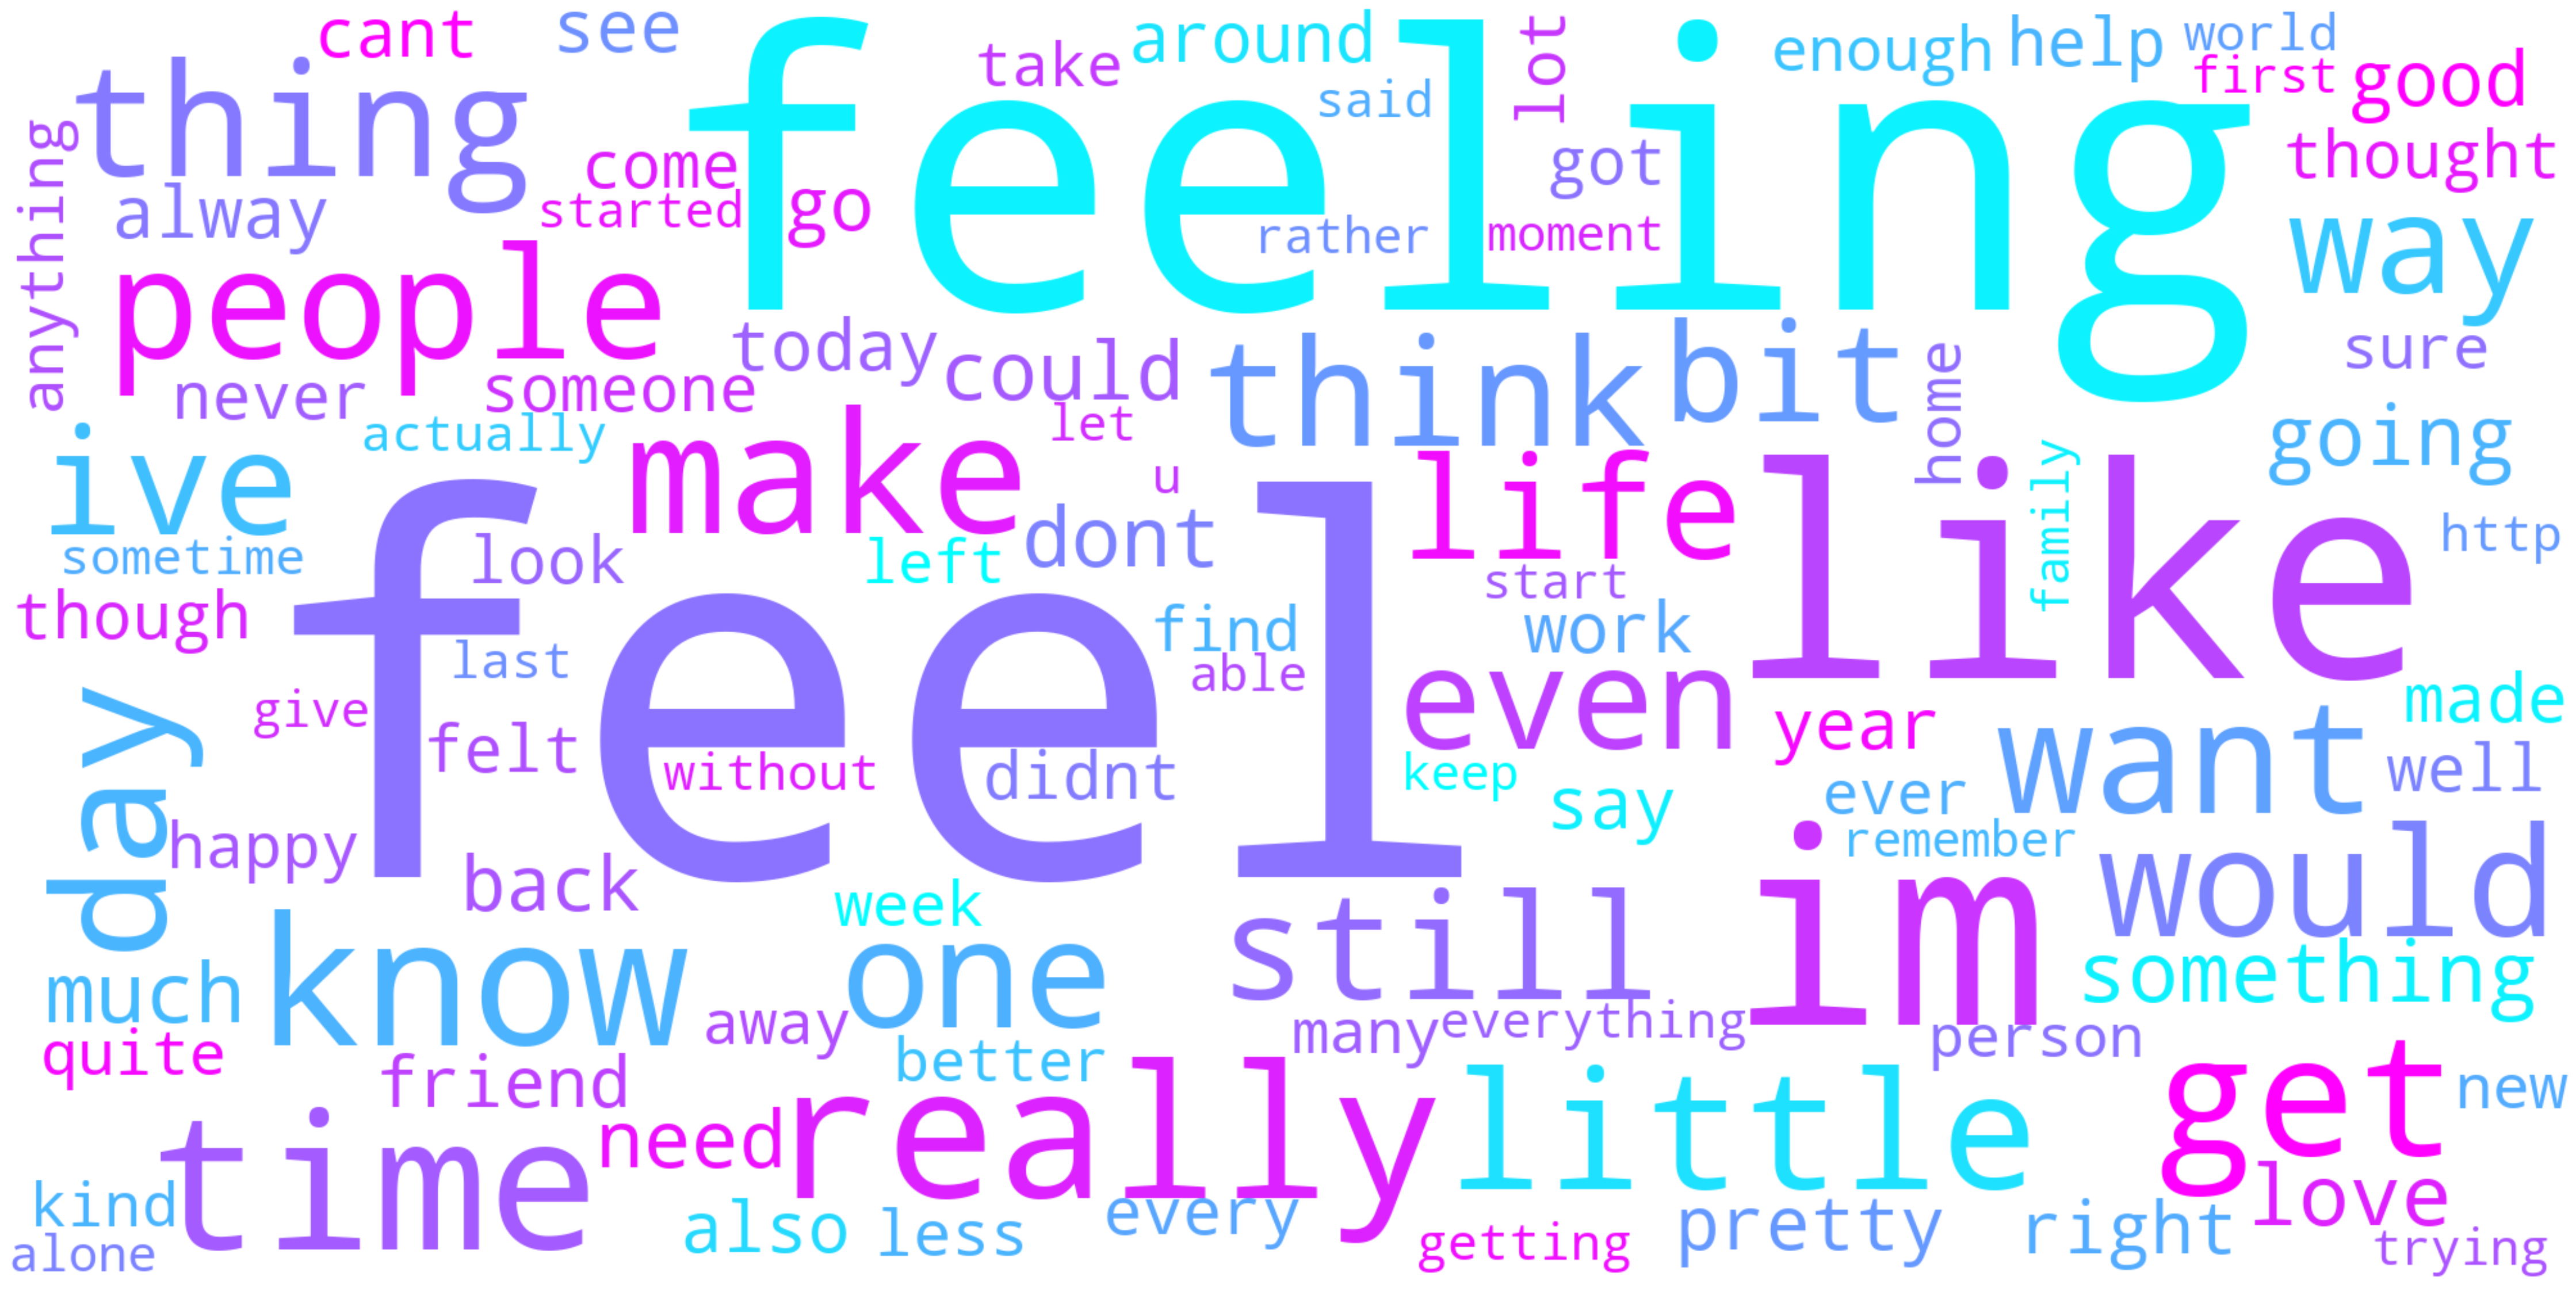

In [33]:
wordcloud = WordCloud(width=2000,
                      height=1000,
                      max_words=100,
                      normalize_plurals=True,
                      font_step=1,
                      relative_scaling=0.5,
                      collocations=False,
                      stopwords = set_stop_words,
                      background_color="white",
                      colormap='cool',
                      include_numbers=False).generate(" ".join(list(train_data.text)))

plt.figure(figsize = (80, 50), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

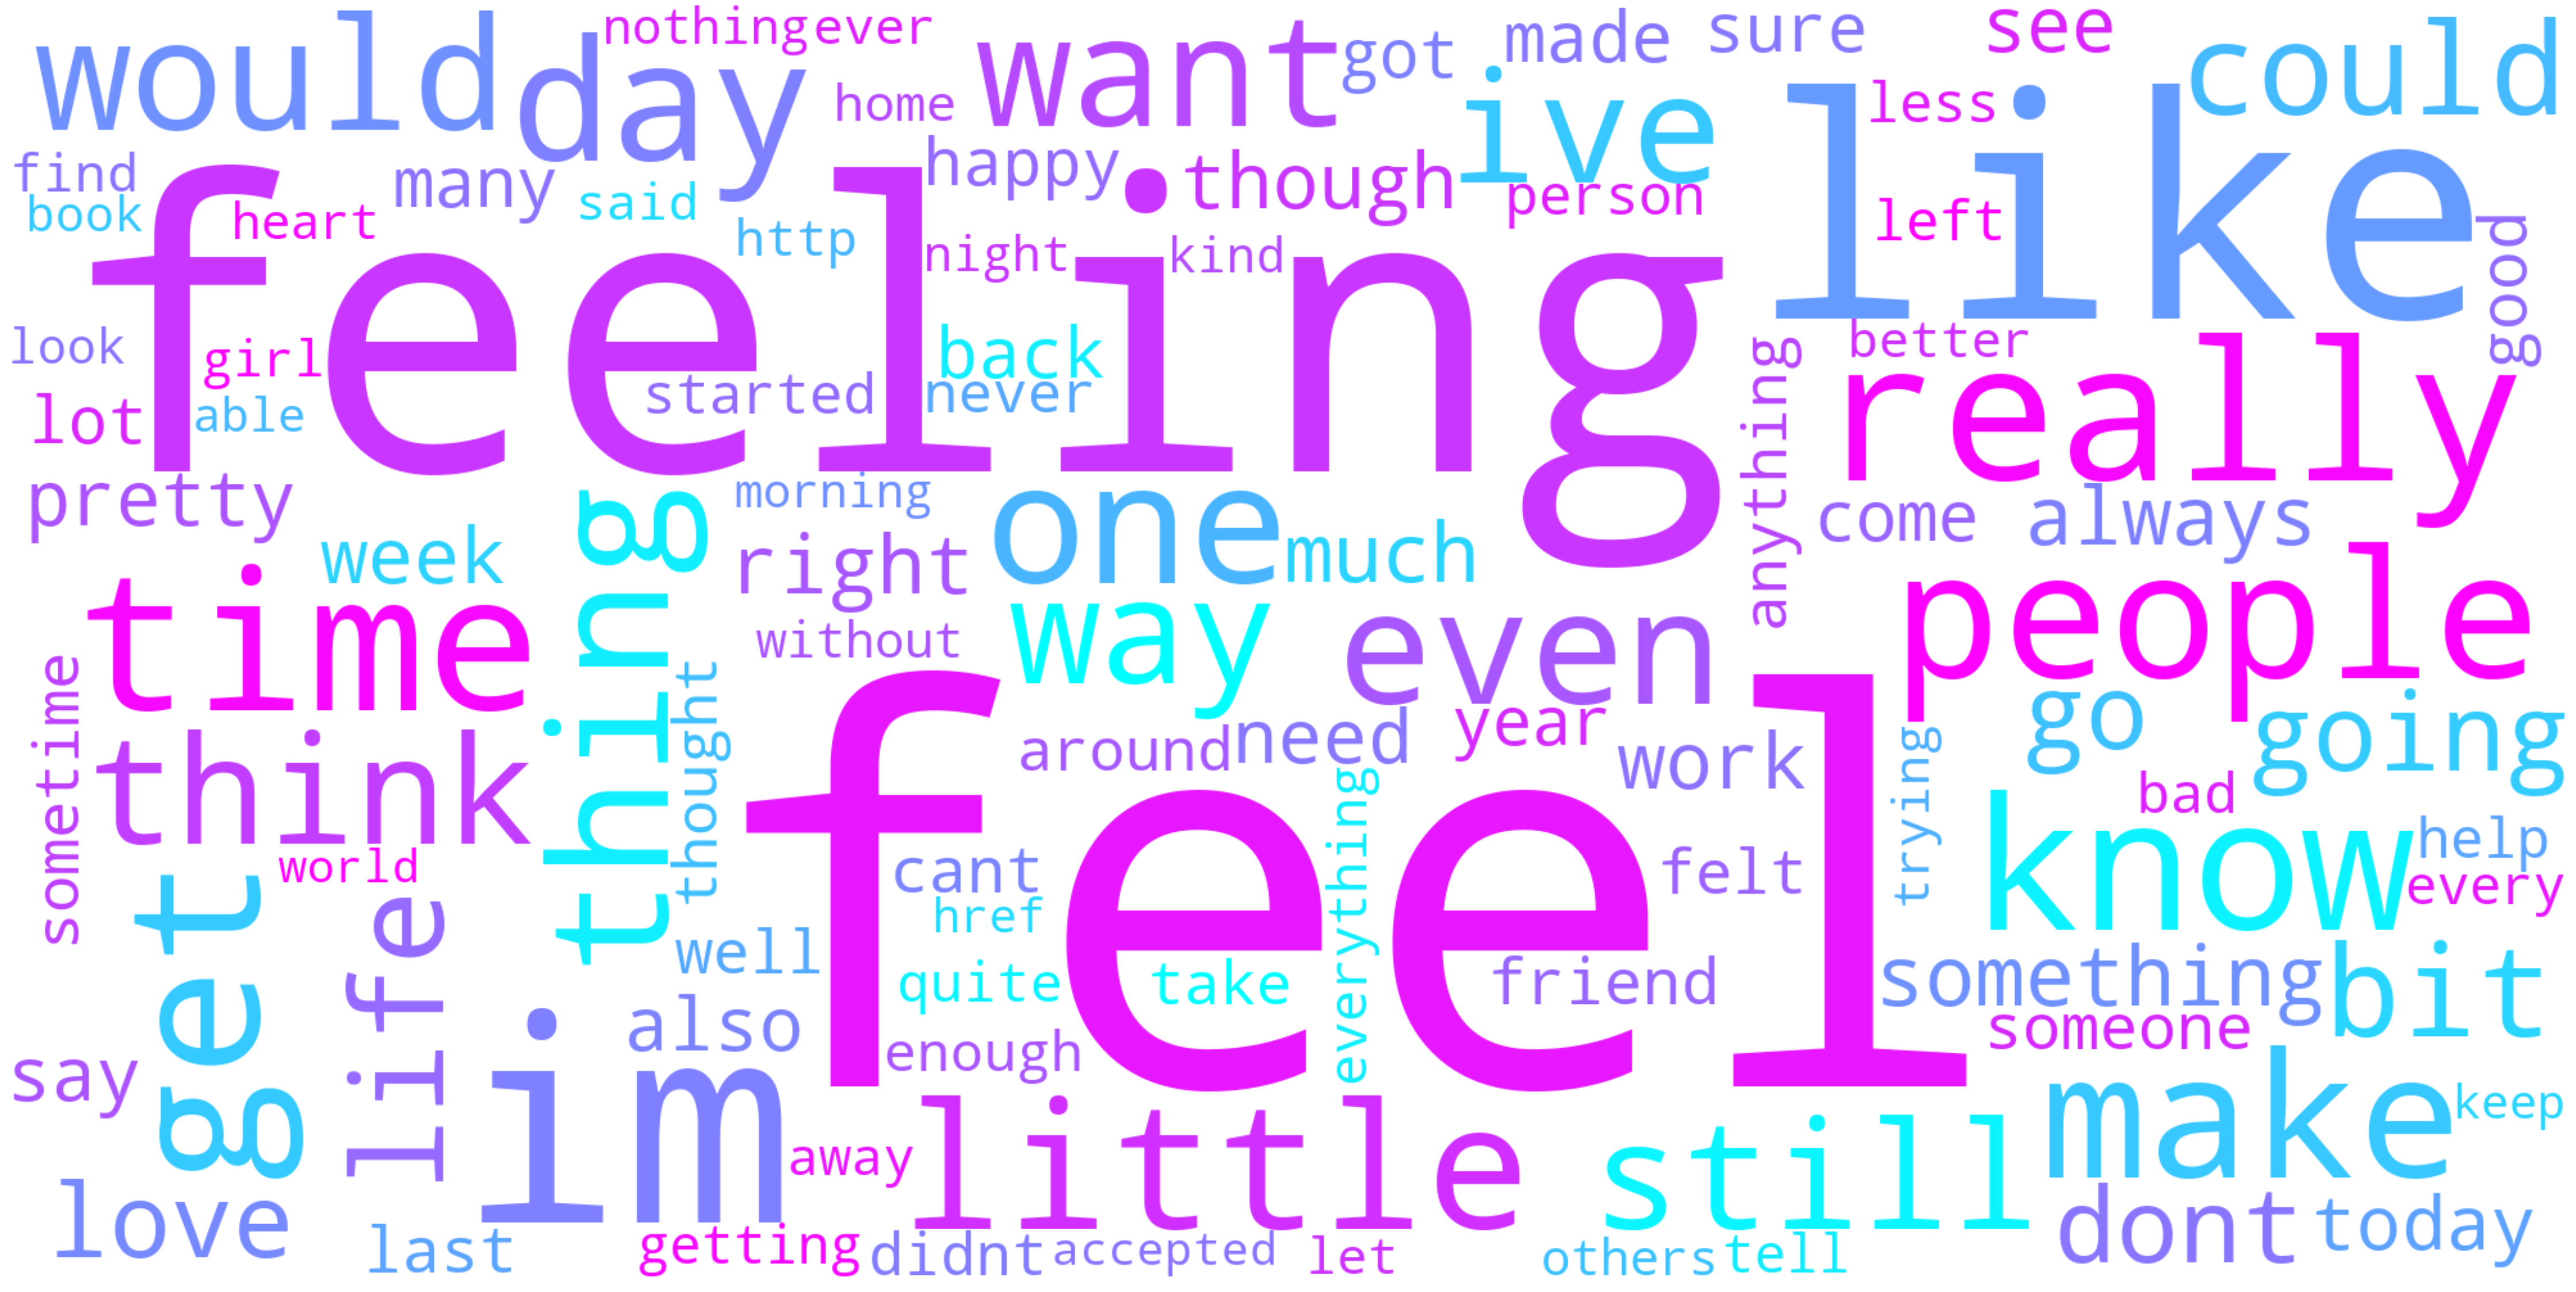

In [34]:
wordcloud = WordCloud(width=2000,
                      height=1000,
                      max_words=100,
                      normalize_plurals=True,
                      font_step=1,
                      relative_scaling=0.5,
                      collocations=False,
                      stopwords = set_stop_words,
                      background_color="white",
                      colormap='cool',
                      include_numbers=False).generate(" ".join(list(test_data.text)))

plt.figure(figsize = (80, 50), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [35]:
def generate_wordcloud(emotion, colormap, text_data): 
    wordcloud = WordCloud(width=500,
                          height=300,
                          max_words=100,
                          normalize_plurals=True,
                          font_step=1,
                          relative_scaling=0.5,
                          collocations=False,
                          stopwords = set_stop_words,
                          background_color="white",
                          colormap=colormap,
                          include_numbers=False).generate(" ".join(list(text_data.text)))
    plt.title('Emotion: ' + emotion)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

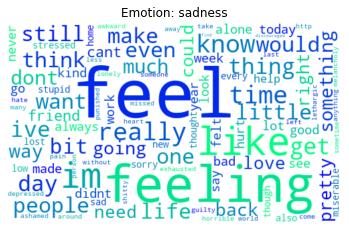

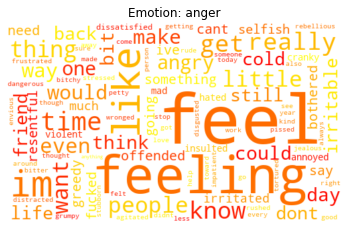

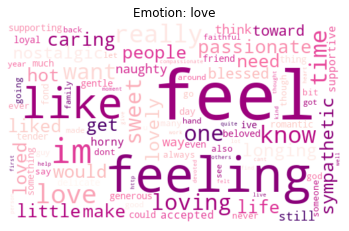

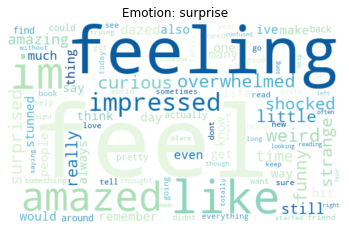

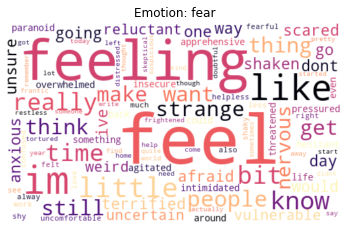

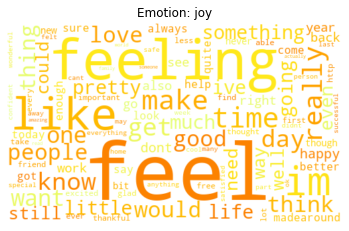

In [36]:
colormaps = {
    'sadness' : 'winter',
    'anger' : 'autumn',
    'love' : 'RdPu',
    'surprise' : 'GnBu',
    'fear' : 'magma',
    'joy' : 'Wistia'
}

for each_cat in train_data.emotion.unique():
    generate_wordcloud(each_cat, colormaps[each_cat], train_data[train_data['emotion'] == each_cat])

##  Text Length Analysis

In [37]:
train_data['length_text'] = train_data.text.apply(len)
test_data['length_text'] = test_data.text.apply(len)

In [38]:
fig = px.box(train_data,
             x='emotion',
             y='length_text',
             color='emotion',
             category_orders={'emotion': emotions_order})
fig.update_yaxes(title='Text Length').update_xaxes(title='Emotions')
fig.show()

In [39]:
fig = px.box(test_data,
             x='emotion',
             y='length_text',
             color='emotion',
             category_orders={'emotion': emotions_order})
fig.update_yaxes(title='Text Length').update_xaxes(title='Emotions')
fig.show()

## Data Distribution per Emotion by Sentiment

In [40]:
train_data['sentiment_hf'] = train_data.text.apply(sentiment_analysis_pipeline)
test_data['sentiment_hf'] = test_data.text.apply(sentiment_analysis_pipeline)

In [41]:
train_data.head()

text  emotion  length_text  \
0                            i didnt feel humiliated  sadness           23   
1  i can go from feeling so hopeless to so damned...  sadness          108   
2   im grabbing a minute to post i feel greedy wrong    anger           48   
3  i am ever feeling nostalgic about the fireplac...     love           92   
4                               i am feeling grouchy    anger           20   

                                        sentiment_hf  
0  [{'label': 'POSITIVE', 'score': 0.891336262226...  
1  [{'label': 'POSITIVE', 'score': 0.966550827026...  
2  [{'label': 'NEGATIVE', 'score': 0.999305427074...  
3  [{'label': 'POSITIVE', 'score': 0.965797126293...  
4  [{'label': 'NEGATIVE', 'score': 0.999391376972...

In [42]:
train_data['sentiment_hf'] = train_data['sentiment_hf'].apply(lambda x : x[0]['label'])
test_data['sentiment_hf'] = test_data['sentiment_hf'].apply(lambda x : x[0]['label'])

In [43]:
fig = px.histogram(train_data,
             x="emotion",
             template='plotly_white',
             color='sentiment_hf',
             category_orders={'emotion': emotions_order})
fig.update_layout(
    title={
        'text': "<b>Train Data</b> Distribution <b>per Emotion by Sentiment</b>",
        'x': 0.5,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Number of Rows').update_xaxes(title='Emotions')
fig.show()

In [44]:
fig = px.histogram(test_data,
             x="emotion",
             template='plotly_white',
             color='sentiment_hf',
             category_orders={'emotion': emotions_order})
fig.update_layout(
    title={
        'text': "<b>Test Data</b> Distribution <b>per Emotion by Sentiment</b>",
        'x': 0.5,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Number of Rows').update_xaxes(title='Emotions')
fig.show()

# Data Preparation

## Label Encoding

In [97]:
train_data["emotion"] = train_data["emotion"].astype('category')
train_data["emotion_label"] = train_data["emotion"].cat.codes
train_data.head()

text  emotion  length_text  \
0                            i didnt feel humiliated  sadness           23   
1  i can go from feeling so hopeless to so damned...  sadness          108   
2   im grabbing a minute to post i feel greedy wrong    anger           48   
3  i am ever feeling nostalgic about the fireplac...     love           92   
4                               i am feeling grouchy    anger           20   

  sentiment_hf  emotion_label  
0     POSITIVE              4  
1     POSITIVE              4  
2     NEGATIVE              0  
3     POSITIVE              3  
4     NEGATIVE              0

In [98]:
test_data["emotion"] = test_data["emotion"].astype('category')
test_data["emotion_label"] = test_data["emotion"].cat.codes
test_data.head()

text  emotion  length_text  \
0  im feeling rather rotten so im not very ambiti...  sadness           59   
1          im updating my blog because i feel shitty  sadness           41   
2  i never make her separate from me because i do...  sadness           97   
3  i left with my bouquet of red and yellow tulip...      joy          113   
4    i was feeling a little vain when i did this one  sadness           47   

  sentiment_hf  emotion_label  
0     NEGATIVE              4  
1     NEGATIVE              4  
2     POSITIVE              4  
3     POSITIVE              2  
4     NEGATIVE              4

## One Hot Encoding and Train Test Data Prep

In [99]:
train_features, train_labels = train_data['text'], tf.one_hot(
    train_data["emotion_label"], 6)
test_features, test_labels = test_data['text'], tf.one_hot(
    test_data["emotion_label"], 6)

In [100]:
train_features[:5]

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: text, dtype: object

In [101]:
train_labels[:5]

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)>

# Generate Word Embeddings

## Analyze & select max_sequnce_length

In [186]:
tokenized_train_features = [word_tokenize(each_train_text) for each_train_text in train_features]
tokenized_test_features = [word_tokenize(each_test_text) for each_test_text in test_features]

In [187]:
list_len_text_by_words = [len(each_tokenized_text) for each_tokenized_text in tokenized_train_features]

In [188]:
fig = px.histogram(
    x=list_len_text_by_words,
    template='plotly_white'
)
fig.update_layout(
    title={
        'text': "Histogram of <b>Sentence Length</b> by Number of Words",
        'x': 0.4,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Frequency').update_xaxes(
    title='Length of Sentences by Words')
fig.update_layout(showlegend=False)
fig.update_layout(hovermode='x')
fig.show()

In [189]:
vector_size = 300

In [190]:
w2v_model = word2vec.Word2Vec(
    tokenized_train_features + tokenized_test_features,
    vector_size=vector_size,  # Dimensionality of the word vectors
    window=20,
    min_count=1,
    sg=1  # 1 for skip-gram; otherwise CBOW
)
w2v_model

In [191]:
# Vocabulary
len(w2v_model.wv)

16182

In [192]:
# Similar Terms Check
w2v_model.wv.most_similar('sad', topn=10)

[('lonely', 0.9200901389122009),
 ('unhappy', 0.8941323161125183),
 ('insecure', 0.8917118310928345),
 ('angry', 0.8817906379699707),
 ('horribly', 0.8794381618499756),
 ('upset', 0.8717057704925537),
 ('indecisive', 0.8676316738128662),
 ('shit', 0.8599379062652588),
 ('uptight', 0.8598623275756836),
 ('hopeless', 0.8596385717391968)]

In [193]:
# Configs for Embedding Layer
vocab_size = len(w2v_model.wv)
max_seq_len = 20

# Get the embedding matrix
vocab = w2v_model.wv.key_to_index.keys()
embedding_matrix = w2v_model.wv[vocab]

In [194]:
vocab_size, vector_size, max_seq_len

(16182, 300, 20)

## Text to Sequences using Gensim

In [195]:
def w2v_indexed_token_sequences(w2v_model, list_features):
    indexed_features = []
    for each_seq in list_features:
        list_token_indices = []
        for each_token in each_seq:
            try:
                list_token_indices.append(w2v_model.wv.key_to_index[each_token])
            except KeyError as e:
                continue
        indexed_features.append(list_token_indices)
    return indexed_features

In [196]:
indexed_train_features = w2v_indexed_token_sequences(w2v_model, tokenized_train_features)

indexed_test_features = w2v_indexed_token_sequences(w2v_model, tokenized_test_features)

len(indexed_train_features), len(indexed_test_features)

(16000, 2000)

## Standardize Sequence Length as Selected Earlier

In [197]:
padded_train = pad_sequences(indexed_train_features, padding = 'post', maxlen=max_seq_len, truncating='post')
padded_test = pad_sequences(indexed_test_features, padding = 'post', maxlen=max_seq_len, truncating='post')

In [198]:
# Check all sequences have same length

list_len_text_by_words = [len(each) for each in padded_train]

fig = px.histogram(
    x=list_len_text_by_words,
    template='plotly_white'
)
fig.update_layout(
    title={
        'text': "Histogram of <b>Sentence Length</b> by Number of Words",
        'x': 0.4,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Frequency').update_xaxes(
    title='Length of Sentences by Words')
fig.update_layout(showlegend=False)
fig.update_layout(hovermode='x')
fig.show()

# Multiclass Classifier

In [216]:
def get_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=vocab_size,
                  output_dim=vector_size,
                  weights=[embedding_matrix],
                  input_length=max_seq_len))
    model.add(Dropout(0.6))
    model.add(LSTM(max_seq_len,return_sequences=True))
    model.add(LSTM(6))
    model.add(Dense(6,activation='softmax'))
    return model

In [217]:
model = get_model()
model.summary()

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\nroy0\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py", line 4489, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "C:\Users\nroy0\anaconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 300)           4854600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 300)           0         
____________________________________________________________

In [218]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [219]:
tf.config.run_functions_eagerly(True)
history = model.fit(padded_train, 
                    train_labels,
                    validation_split=0.33,
                    epochs=5)

Epoch 1/5
335/335 [==============================] - 127s 379ms/step - loss: 1.6265 - accuracy: 0.3168 - val_loss: 1.3406 - val_accuracy: 0.5329
Epoch 2/5
335/335 [==============================] - 123s 367ms/step - loss: 1.2054 - accuracy: 0.5705 - val_loss: 0.8340 - val_accuracy: 0.6747
Epoch 3/5
335/335 [==============================] - 123s 367ms/step - loss: 0.7047 - accuracy: 0.7204 - val_loss: 0.6769 - val_accuracy: 0.7434
Epoch 4/5
335/335 [==============================] - 125s 373ms/step - loss: 0.5145 - accuracy: 0.8210 - val_loss: 0.6176 - val_accuracy: 0.8116
Epoch 5/5
335/335 [==============================] - 124s 370ms/step - loss: 0.3808 - accuracy: 0.8968 - val_loss: 0.6070 - val_accuracy: 0.8175


In [220]:
metric_to_plot = "loss"
epochs = list(range(1, max(history.epoch) + 2))
training_loss = history.history[metric_to_plot]
validation_loss = history.history["val_" + metric_to_plot]

trace1 = {
    "mode": "lines+markers",
    "name": "Training Loss",
    "type": "scatter",
    "x": epochs,
    "y": training_loss
}

trace2 = {
    "mode": "lines+markers",
    "name": "Validation Loss",
    "type": "scatter",
    "x": epochs,
    "y": validation_loss
}

data = Data([trace1, trace2])
layout = {
    "title": "Training - Validation Loss",
    "xaxis": {
        "title": "Number of epochs",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    },
    "yaxis": {
        "title": "Loss",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    }
}
fig = Figure(data=data, layout=layout)
fig.update_layout(hovermode="x unified")
fig.show()

In [221]:
metric_to_plot = "accuracy"
epochs = list(range(1, max(history.epoch) + 2))
training_loss = history.history[metric_to_plot]
validation_loss = history.history["val_" + metric_to_plot]

trace1 = {
    "mode": "lines+markers",
    "name": "Training Accuracy",
    "type": "scatter",
    "x": epochs,
    "y": training_loss
}

trace2 = {
    "mode": "lines+markers",
    "name": "Validation Accuracy",
    "type": "scatter",
    "x": epochs,
    "y": validation_loss
}

data = Data([trace1, trace2])
layout = {
    "title": "Training - Validation Accuracy",
    "xaxis": {
        "title": "Number of epochs",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    },
    "yaxis": {
        "title": "Accuracy",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    }
}
fig = Figure(data=data, layout=layout)
fig.update_layout(hovermode="x unified")
fig.show()

In [227]:
y_pred_one_hot_encoded = (model.predict(padded_train)> 0.5).astype("int32")

In [228]:
y_pred_one_hot_encoded

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [246]:
y_pred = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))

In [250]:
from sklearn.metrics import classification_report
print(classification_report(train_data['emotion_label'], y_pred))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      2159
           1       0.95      0.75      0.84      1937
           2       0.95      0.90      0.93      5362
           3       0.78      0.88      0.83      1304
           4       0.96      0.94      0.95      4666
           5       0.80      0.85      0.82       572

    accuracy                           0.89     16000
   macro avg       0.86      0.87      0.86     16000
weighted avg       0.90      0.89      0.90     16000



In [251]:
y_pred_one_hot_encoded = (model.predict(padded_test)> 0.5).astype("int32")
y_pred = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))
print(classification_report(test_data['emotion_label'], y_pred))

              precision    recall  f1-score   support

           0       0.62      0.88      0.72       275
           1       0.85      0.62      0.72       224
           2       0.87      0.82      0.84       695
           3       0.64      0.76      0.70       159
           4       0.91      0.85      0.88       581
           5       0.64      0.65      0.65        66

    accuracy                           0.80      2000
   macro avg       0.76      0.76      0.75      2000
weighted avg       0.82      0.80      0.80      2000

